# <strong> Example parameterised cradle-to-gate life cycle assessment: Linking BatPaC to Brightway </strong>

Following notebook provides three examples of the linkages between BatPaC to Brightway2 to calculate the cradle-to-gate life cycle emissions of different battery designs.


* [Example 1: Cradle to gate emission of a single battery design](#first-bullet)
* [Example 2: Cradle to gate emission  of several battery design](#second-bullet)
* [Example 3: Cradle to gate emission  of several battery design modular approach](#third-bullet)



<center><img src='../../docs/batpac_bw_link.jpg' width=800/></center>

In [63]:
#Import required packages

import brightway2 as bw
import numpy as np
import pandas as pd
import openpyxl
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group, ParameterManager
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 - 8March2022.xlsm"#ADD PATH


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Example 1 - Linking BatPaC to Brightway: solving one battery system <a class="anchor" id="first-bullet"></a>




First, the material content of a single battery is obtained using BatPaC version 5. The design of the VW ID.4 pack is used. See also the [example battery design notebook](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/example_battery_design.ipynb).

In [3]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                            vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',                              
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 17,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

Battery and vehicle parameters are updated in BatPaC. Use `visible = True` to run BatPaC in the foreground

In [4]:
# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=False)

The Brightway databases and default project parameters (e.g. energy consumption or process yields) are imported. Currently ecoinvent 3.7.1 is used as background database

In [55]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()
    
#Battery LCA setup:
# Import all Brightway2 databases (BW2Package format): 
bat_lca.import_db_brightway()

# Import all project parameters and include default values such as process yield and energy consumption
bat_lca.import_project_parameters()

# # Import the BW activity functions CHECK IF NEEDED IF THE BW2PACKAGES ARE UPLOADED!!!!
# df_act_functions = pd.read_excel(r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model\data\process_formulas.xlsx", sheet_name = 'activity_functions_cut_off')

# bat_lca.import_activity_functions    (df_act_functions)

Biosphere database already present!!! No setup is needed
anode_material  already present
anode_materials  already present
battery_production  already present
cathode  already present
cathode_material  already present
cell_container  already present
cell_other  already present
current_collectors  already present
electrolyte  already present
manufacturing_waste_scrap  already present
module  already present
pack  already present
separator  already present
separators  already present


All battery production activities contain formulas with Brightway project parameters. 
 <br>For example, the activity "mixing cathode materials" in the "battery_production" database contains the following exchanges, formulas and default amounts:

In [6]:
act_cat_mixing = [act for act in bw.Database('battery_production') if act['name']=='mixing cathode materials'][0] 
input = [bw.get_activity(exc['input'])['reference product'] for exc in act_cat_mixing.exchanges()]
formula = [exc['formula'] for exc in act_cat_mixing.exchanges()]
amount = [round(exc['amount'], 2) for exc in act_cat_mixing.exchanges()]
unit = [bw.get_activity(exc['input'])['unit'] for exc in act_cat_mixing.exchanges()]
df_cath_mixing = pd.DataFrame()
df_cath_mixing[['Input product', 'Activity formula', 'Default amount', 'Unit']] = np.array([input, formula, amount, unit]).T
pd.options.display.max_colwidth = 100
df_cath_mixing

,Input product,Activity formula,Default amount,Unit
0,cathode slurry,cathode_slurry,218.48,kilogram
1,binder solvent (NMP),(binder_solvent_nmp/py_am_mixing_total)-binder_solvent_recovered,1.07,kilogram
2,cathode active material (LFP),cathode_active_material_lfp/py_am_mixing_total,0.0,kilogram
3,cathode active material (LMO),cathode_active_material_lmo/py_am_mixing_total,0.0,kilogram
4,cathode active material (NCA),cathode_active_material_nca/py_am_mixing_total,0.0,kilogram
5,cathode active material (NMC333),cathode_active_material_nmc333/py_am_mixing_total,0.0,kilogram
6,cathode active material (NMC532),cathode_active_material_nmc532/py_am_mixing_total,0.0,kilogram
7,cathode active material (NMC622),cathode_active_material_nmc622/py_am_mixing_total,143.15,kilogram
8,cathode active material (NMC811),cathode_active_material_nmc811/py_am_mixing_total,0.0,kilogram
9,cathode binder (PVDF),cathode_binder_pvdf/py_am_mixing_total,2.98,kilogram


The BatPaC battery design outputs are used to update the project parameters and update the exchange amounts in Brightway


In [50]:
#Change BatPaC output to Brightway project names (non-alphanumeric strings)
battery_design_param = bat_lca.output_as_bw_param(result_dict)


#Update the project parameters and recalculate activity amounts in Brightway:
bat_lca.update_param_battery_bw(battery_design_param)



In [8]:
amount_updated = [round(exc['amount'], 2) for exc in act_cat_mixing.exchanges()]

if 'Updated amount' not in df_cath_mixing.columns:
    df_cath_mixing.insert(3, 'Updated amount', 0) 

df_cath_mixing['Updated amount'] = pd.DataFrame(amount_updated)


df_cath_mixing

,Input product,Activity formula,Default amount,Updated amount,Unit
0,cathode slurry,cathode_slurry,218.48,218.48,kilogram
1,binder solvent (NMP),(binder_solvent_nmp/py_am_mixing_total)-binder_solvent_recovered,1.07,1.07,kilogram
2,cathode active material (LFP),cathode_active_material_lfp/py_am_mixing_total,0.0,0.00,kilogram
3,cathode active material (LMO),cathode_active_material_lmo/py_am_mixing_total,0.0,0.00,kilogram
4,cathode active material (NCA),cathode_active_material_nca/py_am_mixing_total,0.0,0.00,kilogram
5,cathode active material (NMC333),cathode_active_material_nmc333/py_am_mixing_total,0.0,0.00,kilogram
6,cathode active material (NMC532),cathode_active_material_nmc532/py_am_mixing_total,0.0,0.00,kilogram
7,cathode active material (NMC622),cathode_active_material_nmc622/py_am_mixing_total,143.15,143.15,kilogram
8,cathode active material (NMC811),cathode_active_material_nmc811/py_am_mixing_total,0.0,0.00,kilogram
9,cathode binder (PVDF),cathode_binder_pvdf/py_am_mixing_total,2.98,2.98,kilogram


The life cycle impacts can now be calculated in Brightway:

In [9]:
lcia_results = {}

#Calculate emissions for all ReCiPe midpoint V.1.13
methods = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method)]

# Set up LCI in Brightway with total pack weight as function unit:
battery_production =bw.Database('battery_production').get(('025dcd4c91fc4eeda276f5fff9ad198e_copy5'))
fu = {battery_production: battery_design_param['battery_pack']}
pack_lca = bw.LCA(fu, methods[0])
pack_lca.lci()
pack_lca.lcia()

# Calculate scores:
for impact_category in methods:
    pack_lca.switch_method(impact_category)
    pack_lca.lcia()
    lcia_results [impact_category] = {}
    lcia_results [impact_category]['score'] = pack_lca.score
    lcia_results [impact_category]['unit'] = bw.Method(impact_category).metadata['unit']

In [10]:
df_total = pd.DataFrame.from_dict(lcia_results).T
df_impact_single = pd.DataFrame()
df_impact_single['score pack'] = df_total['score'].astype(float).round(2)
df_impact_single['score kWh'] = (df_total['score']/battery_design_param['battery_capacity']).astype(float).round(4)
df_impact_single['score kg'] = (df_total['score'].astype(float).round(2)/battery_design_param['battery_pack']).astype(float).round(4)
df_impact_single['unit'] = df_total['unit'] 
df_impact_single


score pack  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP        11057.82   
                                agricultural land occupation    ALOP         357.97   
                                climate change                  GWP100      6219.04   
                                fossil depletion                FDP         2117.12   
                                freshwater ecotoxicity          FETPinf       21.27   
                                freshwater eutrophication       FEP            0.44   
                                human toxicity                  HTPinf      2161.19   
                                ionising radiation              IRP_HE       741.87   
                                marine ecotoxicity              METPinf       30.80   
                                marine eutrophication           MEP            3.21   
                                natural land transformation     NLTP          -1.22   
                                ozone depletion                 ODPinf         0.00   
                                particulate matter formation    PMFP          20.52   
                                photochemical oxidant formation POFP          26.47   
                                terrestrial acidification       TAP100        53.19   
                                terrestrial ecotoxicity         TETPinf        2.16   
                                urban land occupation           ULOP         121.05   
                                water depletion                 WDP          484.95   

                                                                         score kWh  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP       125.7688   
                                agricultural land occupation    ALOP        4.0715   
                                climate change                  GWP100     70.7337   
                                fossil depletion                FDP        24.0796   
                                freshwater ecotoxicity          FETPinf     0.2419   
                                freshwater eutrophication       FEP         0.0050   
                                human toxicity                  HTPinf     24.5808   
                                ionising radiation              IRP_HE      8.4379   
                                marine ecotoxicity              METPinf     0.3503   
                                marine eutrophication           MEP         0.0365   
                                natural land transformation     NLTP       -0.0139   
                                ozone depletion                 ODPinf      0.0000   
                                particulate matter formation    PMFP        0.2334   
                                photochemical oxidant formation POFP        0.3011   
                                terrestrial acidification       TAP100      0.6050   
                                terrestrial ecotoxicity         TETPinf     0.0245   
                                urban land occupation           ULOP        1.3768   
                                water depletion                 WDP         5.5158   

                                                                         score kg  \
ReCiPe Midpoint (H) V1.13 no LT metal depletion                 MDP       22.4220   
                                agricultural land occupation    ALOP       0.7259   
                                climate change                  GWP100    12.6104   
                                fossil depletion                FDP        4.2929   
                                freshwater ecotoxicity          FETPinf    0.0431   
                                freshwater eutrophication       FEP        0.0009   
                                human toxicity                  HTPinf     4.3822   
                                ionising radiation              IRP_HE     1.5043   
                   

#  Example 2 - solving several battery systems
To understand the impact of battery size on pack emissions, in the following example several designs with varying pack energy (30)

The following example calculates the emissions of different battery pack sizes ranging from 30 to 130 kWh (5 kWh step).

We first solve the battery systems in BatPaC. This is relatively time consuming as BatPaC is build in Excel and uses iterative calculations (up to 100) to solve each battery system

In [11]:
dict_design = {}

for energy in range(30, 130+1, 10):
    battery = bd.Battery_system ( vehicle_type='EV', 
                                electrode_pair='NMC622-G (Energy)', 
                                cells_per_module=24, 
                                modules_per_row=6,
                                rows_of_modules=2, 
                                cells_in_parallel=1,
                                silicon_anode= 0.00, 
                                pack_energy=energy, 
                                calculate_fast_charge = 'Yes',
                                max_charging_time = 33,  
                                max_charge_power = 135, 
                                available_energy=94)
    #Establish parameter dictionary
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[energy] = parameter_dict
    
#Solve in BatPaC. Make sure BatPaC is closed!
result_dict_all = bd.solve_batpac_battery_system_multiple (
    batpac_path = path_batpac,
    parameter_dict_all=dict_design, 
    visible=True)

100%|██████████| 11/11 [00:49<00:00,  4.51s/it]


The material content for each design is now calculated

In [12]:
df_mc_all = pd.DataFrame.from_dict([result_dict_all[x]['material_content_pack'] for x in result_dict_all.keys()])
df_mc_all['capacity'] = [result_dict_all[x]['general_battery_parameters']['pack_energy_kWh'] for x in result_dict_all.keys()]
df_mc_all = df_mc_all[df_mc_all>0].dropna(axis=1).set_index('capacity')
df_mc_all.T

capacity,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0,120.0,130.0
anode active material (synthetic graphite),26.389262,34.921758,43.429169,51.919316,60.396842,68.864771,77.325203,85.779665,94.220140,102.664125,111.104751
anode binder (CMC),0.323134,0.427613,0.531786,0.635747,0.739553,0.843242,0.946839,1.050363,1.153716,1.257112,1.360466
anode binder additive (SBR),0.215423,0.285076,0.354524,0.423831,0.493035,0.562161,0.631226,0.700242,0.769144,0.838074,0.906978
anode current collector Cu (10um),10.360331,13.448738,16.502425,19.531641,22.542469,25.538875,28.523612,31.498685,34.462389,37.421730,40.374978
battery jacket,59.883673,63.989311,67.615269,70.900557,73.927748,76.750640,79.406600,81.922832,84.317328,86.610772,88.813648
battery jacket Al,20.512764,22.346814,23.970801,25.445603,26.807381,28.079697,29.278915,30.416949,31.501638,32.542112,33.542931
battery jacket Fe,38.303852,40.476513,42.391003,44.122135,45.714350,47.196604,48.589006,49.906198,51.157903,52.355181,53.503707
battery jacket insulation,1.067057,1.165983,1.253465,1.332819,1.406016,1.474339,1.538679,1.599686,1.657787,1.713479,1.767010
battery management system,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600,3.577600
battery pack,242.683480,288.559184,332.907133,376.172235,418.618765,460.418897,501.692217,542.525786,584.180056,624.308680,664.154280


The life cycle emissions for each design are calculated in Brightway. 

This is relatively time consuming as the project parameters are updated for each battery design. 

A faster approach is presented in example 3 below. 


In [13]:
lcia_results_all = {}

methods = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method)]

#Calculate emissions for GWP100 ReCiPe midpoint V.1.13
cc = [method for method in bw.methods if 'ReCiPe Midpoint (H) V1.13 no LT' in str(method) and 'climate change' in str(method)]

#Update Brightway parameters for each battery system:
for battery_design in result_dict_all.keys():
    result_dict_all[battery_design]['brightway_parameters'] = bat_lca.output_as_bw_param(result_dict_all[battery_design])
    battery = result_dict_all[battery_design]
    bat_lca.update_param_battery_bw(battery['brightway_parameters'])

    battery_production =bw.Database('battery_production').get(('025dcd4c91fc4eeda276f5fff9ad198e_copy5'))
    fu = {battery_production: battery['brightway_parameters']['battery_pack']}
    battery_lca = bw.LCA(fu, methods[2])
    battery_lca.lci()
    battery_lca.lcia()
    lcia_results_all [battery_design] = {}
    lcia_results_all [battery_design]['score'] = battery_lca.score
    lcia_results_all [battery_design]['unit'] = bw.Method(cc[0]).metadata['unit']
    lcia_results_all [battery_design]['capacity-kwh'] =battery['general_battery_parameters']['pack_energy_kWh']
    


The non-linear relation between the impact score and battery pack size is presented below. 

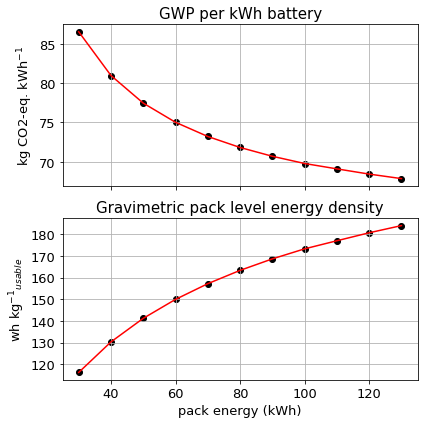

In [14]:
result_total = pd.DataFrame.from_dict(lcia_results_all)
emissions = list(result_total.loc['score']/result_total.loc['capacity-kwh'])

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,6))
ax[0].scatter(result_total.loc['capacity-kwh'], emissions,color='black')
ax[0].plot( result_total.loc['capacity-kwh'],emissions,color='r')
ax[1].scatter(result_total.keys(),[result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh']/result_dict_all[x]['general_battery_parameters']['battery_system_weight']*1000 for x in result_dict_all.keys()], c='black')
ax[1].plot(result_total.keys(),[result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh']/result_dict_all[x]['general_battery_parameters']['battery_system_weight']*1000 for x in result_dict_all.keys()], c='red')

ax[0].set_ylabel('kg CO2-eq. kWh$^{-1}$')
ax[1].set_ylabel(r'wh kg$^{-1}$$_{usable}$')
ax[1].set_xlabel('pack energy (kWh)')

for x in ax.flatten():
    for item in ([x.title, x.xaxis.label, x.yaxis.label] + x.get_xticklabels() + x.get_yticklabels()):
        item.set_fontsize(13)

ax[0].set_title('GWP per kWh battery', fontsize=15)
ax[1].set_title('Gravimetric pack level energy density', fontsize=15)
for x in ax.flatten():
    x.grid(True)

fig.tight_layout()

# Example 3 -  Modular LCA single battery 
The iterative calculation of multiple battery designs by changing the parameters in Brightway is relatively slow to solve many battery designs. 

<br>Instead, a more efficient way is the use of precalculated gate-to-gate LCA modules based on [Steubing et al., 2016](https://link.springer.com/article/10.1007/s11367-015-1015-3).


The first step is to establish the base product-module matrix ($A'$). 
To obtain this matrix, a new Brightway database is established containing all relevant modules that need to be cut-off and representing the foreground system


In [57]:
# %%capture

activities= []
count = []
#check if the cut-off db already present:


def format_me(list_of_activities, database_obj):
    return {(database_obj.name, obj['code']): obj for obj in list_of_activities}

if 'cut_off' in bw.databases:
    cut_off_db =  bw.Database('cut_off')

    
if 'cut_off' not in bw.databases:
    cut_off_db =  bw.Database('cut_off')
    cut_off_db.register()
    for row in bat_lca.df_cut_off_modules.iterrows():
        act = bw.Database(row[1]['database']).get(row[1]['code'])
        if act not in bw.Database('cut_off'):
            act.copy(database="cut_off")
            act.save()
        
    bat_lca.add_activity_parameters('cut_off')


Next we relink the databases of the exchanges and corresponding activities to the "cut_off" database. For now we use Activity Browser and relink exchanges to the 'cut_off' database.


After relinking the exchanges, a dictionary with all activities present in the 'cut_off' database and their 'cut' exchanges is established. 

Exchanges are cut off if the corresponding activity is present in 'cut_off' 
E.g. Aluminium alloy, PET, PE and freight train transport are all present in the 'cut of database' and will be cut in the cell container production activity: 

In [67]:
import importlib
importlib.reload(bat_lca)


cut_off_dictionary = bat_lca.modules_with_cuts('cut_off')
cut_off_dictionary['cell container production']

{'key': ('cut_off', 'e2c0c7bedc2d4ef4bdd6cc285bf36ee4'),
 'output': 'cell container',
 'amount': 1.0,
 'cuts': {('cut_off',
   '96faf680592248d084cf81ccfb31effa'): ['aluminium, wrought alloy', -0.8173891983531123],
  ('cut_off',
   '7ee61e3415ee4e728f0001a2ffcfc1f6'): ['polyethylene terephthalate, granulate, amorphous', -0.12533301041414388],
  ('cut_off', '6f7138307ac24250be4698902cedef21'): ['polypropylene, granulate',
   -0.057277791232744006],
  ('cut_off', '2f9511af7ed64f6d9150b4aafce9bff2'): ['transport, freight train',
   -0.0438]}}

Exchanges are cut off from activities by simply setting their amount to zero in brightway

In [68]:
#Cut modules, setting all cut-off exchanges to zero:
bat_lca.cut_modules_to_zero(cut_off_dictionary)

As you can see, the aluminium, PET, PE and freight train transport exchanges for the cell container activity are now all set to zero:

In [70]:
[exc for exc in bw.get_activity(cut_off_dictionary['cell container production']['key']).exchanges()]

[Exchange: 1.0 kilogram 'cell container production' (kilogram, RER, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 0.11455558246548801 kilogram 'extrusion, plastic film' (kilogram, RER, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 0 kilogram 'market for aluminium, wrought alloy' (kilogram, GLO, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 0.8173891983531123 kilogram 'sheet rolling, aluminium' (kilogram, RER, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 0 kilogram 'market for polyethylene terephthalate, granulate, amorphous' (kilogram, GLO, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 0 kilogram 'market for polypropylene, granulate' (kilogram, GLO, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 3.5e-10 unit 'plastic processing factory construction' (unit, RER, None) to 'cell container production' (kilogram, RER, None)>,
 Exchange: 

In [71]:
# Divide all battery production activities by total battery system weight:
bat_product_act = [act['name'] for act in bw.Database('battery_production')]
for act in bat_product_act:
    pack_weight = battery_design_param['battery_pack']
    cut_off_dictionary[act]['amount'] = cut_off_dictionary[act]['amount']/pack_weight
    for exc in cut_off_dictionary[act]['cuts'].keys():
        cut_off_dictionary[act]['cuts'][exc][1] = cut_off_dictionary[act]['cuts'][exc][1]/pack_weight
        

Now the emissions of all modules can be calculated in Brightway:

In [73]:
#Select all Recipe Midpoint impacts:
impacts = [m for m in bw.methods if 'ReCiPe Midpoint (H) V1.13' in str(m) and 'no LT' in str(m)]
H_m = bat_lca.lcia_modules (cut_off_dictionary, impacts)

The total emissions of a pack can now be calculated by multiplying the module emissions ($\bf{h}$) with the scaling vector ($\bf{s}$):

$$ h= \mathbf{h} \mathbf{s}$$

where the scaling vector is calculated by the inverse of the foreground modular and parameterised technology matrix ($\mathbf{A}$) and the final demand vector ($\mathbf{f}$) based on the general matrix LCA formula:

$$ \mathbf{s} = \mathbf{A}^{-1} \mathbf{f} $$



CONTINUE
As the $\mathbf{A}$ matrix parameters for different battery designs outside the Brightway environment.


using `calculate_modular_A`




In [74]:
# We first establish a pandas dataframe of the cut_off dictionary
df_A_matrix = bat_lca.modular_technology_matrix(cut_off_dictionary)

# Next, we solve the A matrix for the different battery design configurations

# The A matrix for each design are stored in a nested numpy array:
A_matrix_nested = np.zeros([len(result_dict_all.keys()), df_A_matrix.shape[0], df_A_matrix.shape[1]])
# Empty nested scaling vector:
s_nested = np.zeros([len(result_dict_all.keys()), A_matrix_nested.shape[1]])

# we use the default process parameters (e.g. process yields or energy consumption) as defined in Brightway:
project_param = bat_lca.get_project_parameters_dict(result_dict)

for idx, k in enumerate(result_dict_all.keys()):
    # all process and battery design paramaters
    param_dict = {**project_param, **bat_lca.output_as_bw_param(result_dict_all[k])}
    # Formulas for each design are solved and the A matrix obtained:
    A_matrix_temp = bat_lca.calculate_modular_A(df_A_matrix, param_dict)
    # Inversion of the A matrix
    A_inv = np.linalg.pinv(A_matrix_temp)
    # Function unit is battery pack weight of the specific design
    pack_weight = param_dict["battery_pack"]
    y = pd.Series(data=0, index=df_A_matrix.index)
    y.loc["battery pack"] = pack_weight
    # Obtain the scaling vector the design
    s_nested[idx] = A_inv.dot(y)


The emissions for each design can now be calculated by multiplying the design specific scaling vector with the modular emissions 

In [76]:
# Using np.einsum to obtain the total emissions per battery:
h_all_design = np.einsum('i, ki -> ki', H_m[:,2], s_nested  )# 2 refers to the GWP100 impact category

The total emissions per kWh for the base system are identical to the emissions when solved fully in Brightway but substantial faster to solve the parameterised activities.

Text(0, 0.5, 'kg CO2-eq. kWh$^{-1}$')

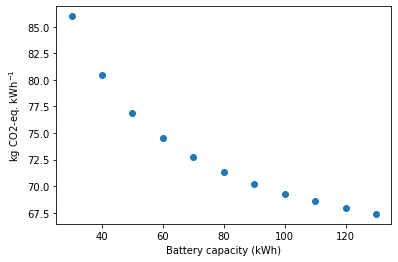

In [182]:
capacity = [int(result_dict_all[x]['general_battery_parameters']['pack_energy_kWh']) for x in result_dict_all.keys()]
gwp_per_kwh = [h_all_design.sum(axis=1)[idx]/x for idx, x in enumerate(capacity)]
plt.scatter(capacity, gwp_per_kwh)
plt.xlabel('Battery capacity (kWh)')
plt.ylabel('kg CO2-eq. kWh$^{-1}$')



And the contribution of each module:

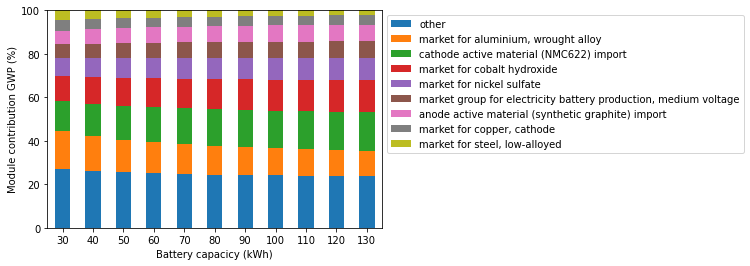

In [212]:
df_gwp_results = pd.DataFrame(h_all_design, columns=df_A_matrix.columns, index=capacity).T/capacity

idx = (df_gwp_results.sort_values(by=capacity[0], ascending=False).head(8)).index.to_list()
idx_other = [x for x in df_gwp_results.index.to_list() if x not in idx]
df_aggregated = pd.DataFrame(columns = df_gwp_results.columns, index= idx)
df_aggregated.loc[idx] = df_gwp_results.loc[idx]
df_aggregated.loc['other'] = df_gwp_results.loc[idx_other].sum()

fig, ax = plt.subplots(1, 1,figsize=(6,4))

(df_aggregated/gwp_per_kwh*100).sort_values(by=capacity[0], ascending=False).T.plot.bar(ax=ax, stacked=True, rot=0 )
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim([0,100])
ax.set_xlabel('Battery capacicy (kWh)')
ax.set_ylabel('Module contribution GWP (%)');


In [213]:
countries = ['NO', 'SE', 'GB', 'DE', 'FR', 'SK', 'PL', 'IT', 'HU']

fu_electricity = []
#Just for GWP:
impact_category = [m for m in bw.methods if 'ReCiPe Midpoint (H) V1.13' in str(m) and 'no LT' in str(m)][2]


electricity_act = [act for act in bw.Database('eidb 3.7') if act['name'] == 'market for electricity, medium voltage']
#Get electricity activities for all countries
for country in countries:
    act =  [act for act in electricity_act if act['location']==country][0]
    fu_electricity.append({act:1})

bw.calculation_setups['multi_lca'] = {'inv': fu_electricity, 'ia': [impact_category]}
MultiLCA = bw.MultiLCA('multi_lca')

In [225]:
H_m[df_A_matrix.columns.get_loc( 'market group for electricity battery production, medium voltage'),2]

0.35484360490714

In [228]:
pd.DataFrame(H_m.T, index=impacts, columns = df_A_matrix.columns).to_clipboard()

In [215]:
h_all_design = np.einsum('i, ki -> ki', H_m[:,2], s_nested  )# 2 refers to the GWP100 impact category

array([[0.01957827],
       [0.03710747],
       [0.33283009],
       [0.57187764],
       [0.10544517],
       [0.51133695],
       [0.97591368],
       [0.43518664],
       [0.44110332]])

In [217]:
H_m.shape

(132, 18)

In [214]:
for x in range(len(MultiLCA.results)):
    #change h value:
    h_gwp[A_matrix.columns.get_loc('market for electricity, medium voltage')] = MultiLCA.results[x]
    total_emission_country.append( h_gwp.dot(s_vector)/capacity/process_parameters['battery_manufacturing_capacity'])